In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
from rasterio.features import rasterize
from tqdm import tqdm
import os

output_dir = "../output/"

In [2]:
# load landcover and NDVI data
lc_crop = np.load("../data/lc_crop_all.npy")
ndvi = np.load("../data/ndvi_all.npy")

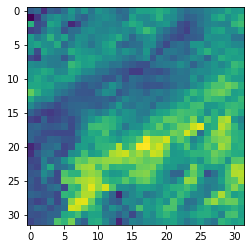

In [3]:
plt.imshow(ndvi[0])

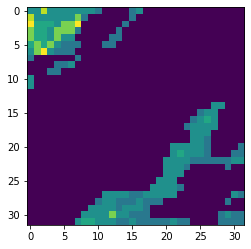

In [4]:
plt.imshow(lc_crop[0])

In [5]:
# load fire event data
fire_event_df = gpd.read_file('../data/fired_conus-ak_events_nov2001-march2021.gpkg')
fire_day_df=gpd.read_file('../data/fired_conus-ak_daily_nov2001-march2021.gpkg')

## Select the medium scale fire events 

In [6]:
medium_fire_event=fire_event_df[(fire_event_df.area >= 10e6) & (fire_event_df.area <= 30e6) & (fire_event_df.event_dur > 3)]
medium_event_bounds=medium_fire_event.bounds
medium_event_bounds["width"]=((medium_event_bounds["maxx"]-medium_event_bounds["minx"])/463.3127165283333).astype(int)
medium_event_bounds["height"]=((medium_event_bounds["maxy"]-medium_event_bounds["miny"])/463.3127165283333).astype(int)

def return_transform_object(west, south, east, north, width, height):
    return rio.transform.from_bounds(west, south, east, north, width, height)

medium_event_bounds["transform"]=medium_event_bounds.apply(lambda x: return_transform_object(x["minx"], x["miny"], x["maxx"], x["maxy"], x["width"], x["height"]), axis=1)
medium_fire_event=medium_fire_event.join(medium_event_bounds)

medium_fire_day=fire_day_df[[True if a in medium_fire_event["id"].values else False for a in fire_day_df["id"] ]]

medium_fire_day["event_id"]=medium_fire_day["id"].values
medium_fire_event["event_id"]=medium_fire_event["id"].values

medium_fire_event["date"]=pd.to_datetime(medium_fire_event["ig_date"])
medium_fire_event["envelope_centroid"]=medium_fire_event.envelope.centroid.to_crs("EPSG:4326")

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Add landcover and NDVI data into the dataset

In [7]:
medium_fire_event["ndvi"]=lc_crop.tolist()
medium_fire_event["land_cover"]=ndvi.tolist()

## Add digital elevation model

In [8]:
dem_img=rio.open("../data/US_GMTED_MODIS.tif")
dem=dem_img.read(1)

In [9]:
dem_list=[]
for i in range(len(medium_fire_event)):
    g=medium_fire_event.iloc[i].geometry.bounds
    ul=list(rio.transform.rowcol(dem_img.transform, g[0], g[3]))
    cell_size=463.43036
    x_err=(rio.transform.xy(dem_img.transform, ul[0], ul[1])[0]-463.43036/2)-g[0]
    y_err=(rio.transform.xy(dem_img.transform, ul[0], ul[1])[1]+463.43036/2)-g[3]
    
    if x_err < -cell_size/2:
        ul[1]=ul[1]+1
    elif (x_err > cell_size/2):
        ul[1]=ul[1]-1

    if y_err > cell_size/2:
        ul[0]=ul[0]+1
    elif y_err < -cell_size/2:
        ul[0]=ul[0]-1
   
    h=medium_fire_event.iloc[i].height
    w=medium_fire_event.iloc[i].width
    
    
    dim=32

    h_dif=dim-h
    w_dif=dim-w
    left_pad=w_dif//2
    right_pad=w_dif-left_pad
    top_pad=h_dif//2
    bottom_pad=h_dif-top_pad
    
    dem_crop=dem[ul[0]-top_pad:ul[0]+h+bottom_pad, ul[1]-left_pad:ul[1]+w+right_pad]
    
    dem_list.append(dem_crop)
    

In [10]:
medium_fire_event["dem"]=dem_list

In [11]:
#dem[ul[0]-top_pad:ul[0]+h+bottom_pad, ul[1]-left_pad:ul[1]+w+right_pad]
#dem[-1258438253,-1881336129]
#ul[0]-top_pad
dem_crop=dem[ul[0]-top_pad:ul[0]+h+bottom_pad, ul[1]-left_pad:ul[1]+w+right_pad]

## Rasterize

In [17]:
medium_fire=medium_fire_day.merge(medium_fire_event[["event_id", "minx", "miny", "maxx", "maxy", "width", "height", "transform", "dem", "ndvi", "land_cover", "envelope_centroid"]], on="event_id")
medium_fire=medium_fire[(medium_fire.width < 32) & (medium_fire.height < 32)]

def return_raster(geom, height, width, trans):
    return rasterize([geom,], out_shape=(height, width), transform=trans)
medium_fire["raster"]=medium_fire.apply(lambda x: return_raster(x["geometry"], x["height"], x["width"], x["transform"]), axis=1)

def padding(org, dim=32):
    h=org.shape[0]
    w=org.shape[1]
    h_dif=dim-h
    w_dif=dim-w
    left_pad=w_dif//2
    right_pad=w_dif-left_pad
    top_pad=h_dif//2
    bottom_pad=h_dif-top_pad
    return np.pad(org, ((top_pad, bottom_pad), (left_pad, right_pad)), 'constant', constant_values=0)

medium_fire["padded_raster"]=medium_fire["raster"].apply(padding)

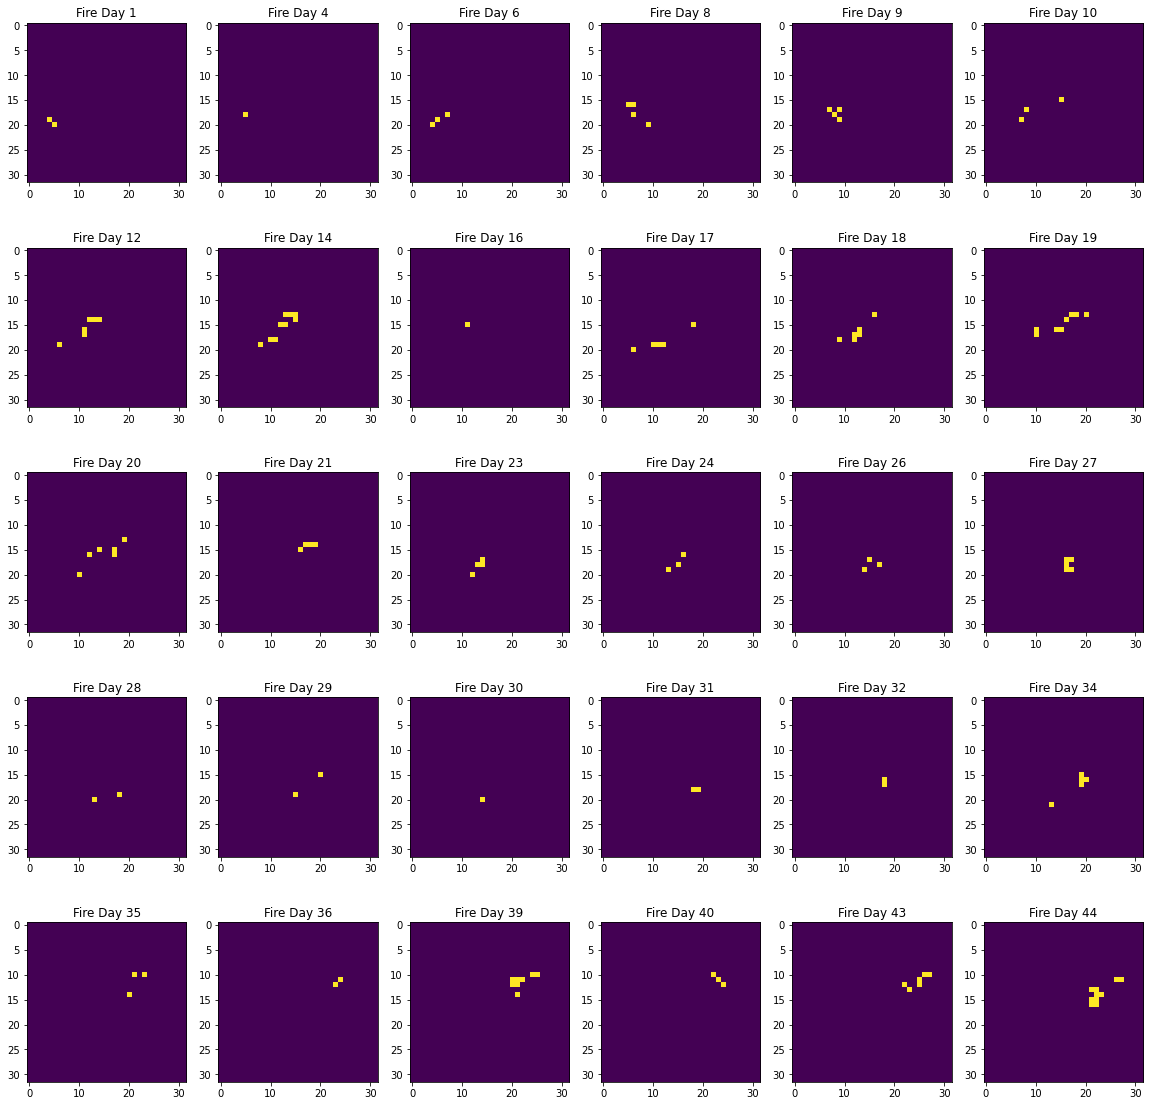

In [18]:
fig, axs=plt.subplots(5,6, figsize=(20,20))
ax=axs.flatten()
longest_fire=medium_fire[medium_fire.event_id==154860]
for i in range(30):
    ax[i].imshow(longest_fire["padded_raster"].iloc[i])
    ax[i].set_title("Fire Day {}".format(longest_fire["event_day"].iloc[i]))

## Get meterological variables

In [19]:
import urllib3
import urllib
import cdsapi
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
c = cdsapi.Client(quiet=True)

In [20]:
medium_fire["date"]=pd.to_datetime(medium_fire.date)

In [21]:
medium_fire_no_ak=medium_fire[[medium_fire["envelope_centroid"].iloc[i].__geo_interface__["coordinates"][1] < 49.5 for i in range(len(medium_fire))]]
medium_fire_no_ak_hi=medium_fire_no_ak[[medium_fire_no_ak["envelope_centroid"].iloc[i].__geo_interface__["coordinates"][0] > -125 for i in range(len(medium_fire_no_ak))]]

In [22]:
id_list=np.sort(np.unique(medium_fire_no_ak_hi["event_id"].values))

In [23]:
medium_fire_no_ak_hi["ndvi"]=[np.array(d) for d in medium_fire_no_ak_hi["ndvi"]]

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [24]:
medium_fire_no_ak_hi["land_cover"]=[np.array(d) for d in medium_fire_no_ak_hi["land_cover"]]

In [25]:
stack_list=[]

In [29]:
for i in tqdm(range(len(id_list))):
    temp_df=medium_fire_no_ak_hi[medium_fire_no_ak_hi["event_id"]==id_list[i]]
    fire_stack=np.stack(temp_df["padded_raster"].to_numpy())
    ndvi_stack=np.stack(temp_df["ndvi"].to_numpy())
    lc_stack=np.stack(temp_df["land_cover"].to_numpy())
    #dem_stack=np.stack(temp_df["dem"].to_numpy())
    #stack=np.stack([fire_stack, ndvi_stack, lc_stack, dem_stack])
    stack=np.stack([fire_stack, ndvi_stack, lc_stack])
    stack_list.append(stack)

100%|██████████████████████████████████████| 5079/5079 [00:06<00:00, 743.10it/s]


In [34]:
import pickle
with open(output_dir+"fire_conus_no_meteo_and_dem.pickle", "wb") as fp:   #Pickling
    pickle.dump(stack_list, fp)

In [ ]:
%%time
u10_list=[]
v10_list=[]
t2m_list=[]

from tqdm.notebook import tqdm
import xarray as xr

for i in tqdm(range(len(medium_fire_no_ak_hi))):
    c = cdsapi.Client(quiet=True)
    env_cen_x=medium_fire_no_ak_hi["envelope_centroid"].iloc[i].__geo_interface__["coordinates"][0]
    env_cen_y=medium_fire_no_ak_hi["envelope_centroid"].iloc[i].__geo_interface__["coordinates"][1]
    hour=((np.array([2, 8, 14,  22]) - np.floor((-125+ 7.5) / 15)) % 24).tolist()
    this_day=medium_fire_no_ak_hi["date"].iloc[i]
    next_day=this_day+np.timedelta64(1, 'D')

    day_list=[]
    month_list=[]
    year_list=[]
    
    day_list.append(this_day.day)
    day_list.append(next_day.day)
    month_list.append(this_day.month)
    year_list.append(this_day.year)    
    if this_day.month != next_day.month:
        month_list.append(next_day.month)
    if this_day.year != next_day.year:
        year_list.append(next_day.year)

    day_list=[str(d).zfill(2) for d in day_list]
    month_list=[str(m).zfill(2) for m in month_list]
    year_list=[str(y) for y in year_list]

    fl=c.retrieve(
        'reanalysis-era5-land',
        {
            'format': 'netcdf',
            'variable': [
                '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature',
            ],
            'day': day_list,
            'year': year_list,
            'month': month_list,
            'time': [str(int(h)).zfill(2)+":00" for h in hour],
            'area': [
                env_cen_y, env_cen_x, env_cen_y-0.1,
                 env_cen_x+0.1,
            ],
        })

    with urllib.request.urlopen(fl.location) as f:
        ds = xr.open_dataset(f.read())

    time_list=[this_day + np.timedelta64(int(hour[0]), 'h'),
    this_day + np.timedelta64(int(hour[1]), 'h'),
    this_day + np.timedelta64(int(hour[2]), 'h'),
    next_day + np.timedelta64(int(hour[3]), 'h')]

    u10=ds.sel(time=time_list).u10[:,0,0].values
    v10=ds.sel(time=time_list).v10[:,0,0].values
    t2m=ds.sel(time=time_list).t2m[:,0,0].values
    
    u10_list.append(u10)
    v10_list.append(v10)
    t2m_list.append(t2m)

In [ ]:
dem_list=[]
i = 1
g=medium_fire_event.iloc[i].geometry.bounds
ul=list(rio.transform.rowcol(dem_img.transform, g[0], g[3]))
cell_size=463.43036
x_err=(rio.transform.xy(dem_img.transform, ul[0], ul[1])[0]-463.43036/2)-g[0]
y_err=(rio.transform.xy(dem_img.transform, ul[0], ul[1])[1]+463.43036/2)-g[3]

if x_err < -cell_size/2:
    ul[1]=ul[1]+1
elif (x_err > cell_size/2):
    ul[1]=ul[1]-1

if y_err > cell_size/2:
    ul[0]=ul[0]+1
elif y_err < -cell_size/2:
    ul[0]=ul[0]-1

h=medium_fire_event.iloc[i].height
w=medium_fire_event.iloc[i].width


dim=32

h_dif=dim-h
w_dif=dim-w
left_pad=w_dif//2
right_pad=w_dif-left_pad
top_pad=h_dif//2
bottom_pad=h_dif-top_pad

dem_crop=dem[ul[0]-top_pad:ul[0]+h+bottom_pad, ul[1]-left_pad:ul[1]+w+right_pad]

dem_list.append(dem_crop)


In [ ]:
ul[0]

In [ ]:
list(rio.transform.rowcol(dem_img.transform, g[0], g[3]))

In [ ]:
g[0]

In [ ]:
g

In [ ]:
dem_crop=dem[ul[0]-top_pad:ul[0]+h+bottom_pad, ul[1]-left_pad:ul[1]+w+right_pad]

In [ ]:
dem_crop

In [ ]:
dem.shape

In [ ]:
dem[ul[0]-top_pad:ul[0]+h+bottom_pad]

In [ ]:
dem[ul[0]-top_pad:ul[0]+h+bottom_pad, ul[1]-left_pad:ul[1]+w+right_pad]

In [ ]:
ul[0]-top_pad

In [ ]:
ul[0]+h+bottom_pad

In [ ]:
ul[1]-left_pad

In [ ]:
ul[1]+w+right_pad

In [ ]:
dem[-740380502:-740380470,-1921588741:-1921588709]

In [ ]:
dem[1:3,3:5]

In [46]:
np.shape(stack_list[4])

(3, 5, 32, 32)

In [47]:
len(stack_list)

5079